# Feature Extraction

In [13]:
from pathlib import Path
import pandas as pd
import anndata as ad
organized_data_dir = Path("/Users/projects_data/project_MLPhenotypesMRIGWAS/organized_data/23_03_30")
ml_generated_dir = Path("/Users/projects_data/project_MLPhenotypesMRIGWAS/ml_generated_data/23_03_30/preprocessed_data/")

In [14]:
adata = ad.read("/Users/projects_data/project_MLPhenotypesMRIGWAS/ml_generated_data/23_03_30/preprocessed_data/minmax_adata.h5ad")

In [15]:
feature_missingness = pd.read_csv(ml_generated_dir / "features_missingness.csv")

In [16]:
with open(organized_data_dir / "ADNI_PPMI_UKBB_t1imaging_invicro_features.txt", 'r') as f:
    flist = f.read().split('\n')

In [17]:
feature_missingness['include_classification'] = feature_missingness['missing_fraction'].map(lambda x: 'N' if x > 1 else 'Y')
feature_missingness.columns = ['Feature ID', 'Missing data (%)', 'Included in ML model (Y/N)']
feature_missingness.sort_values(by='Missing data (%)', ascending=False).to_csv("Step1_preprocessing/feature_missingness_details.csv", sep=',', index=False)

# Participants characteristics

In [18]:
ad_adata = ad.read("/Users/projects_data/project_MLPhenotypesMRIGWAS/ml_generated_data/23_03_30/predictiveModel/ad_imaging.h5ad")
pd_adata = ad.read("/Users/projects_data/project_MLPhenotypesMRIGWAS/ml_generated_data/23_03_30/predictiveModel/pd_imaging.h5ad")
for_ethnicity = pd.read_csv("/Users/EssentialCodeBase/data/brain_imaging/raw_data/23_03_invicro/adni_t1w.csv")

/var/folders/y5/tr1yp82s2ns2_4g_6flxk45jrqb07t/T/ipykernel_72570/400617496.py:3: DtypeWarning: Columns (0,20,21,22,51,80,105,106,107,117,119,732,733,991) have mixed types. Specify dtype option on import or set low_memory=False.
  for_ethnicity = pd.read_csv("/Users/dadua2/EssentialCodeBase/data/brain_imaging/raw_data/23_03_invicro/adni_t1w.csv")


In [19]:
for_ethnicity_ppmi = pd.read_csv("/Users/EssentialCodeBase/data/clinical/raw_data/23_03_unknown/processed_uniq_visit_month_mean_U3.csv")

/var/folders/y5/tr1yp82s2ns2_4g_6flxk45jrqb07t/T/ipykernel_72570/1517997466.py:1: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  for_ethnicity_ppmi = pd.read_csv("/Users/dadua2/EssentialCodeBase/data/clinical/raw_data/23_03_unknown/processed_uniq_visit_month_mean_U3.csv")


In [20]:
# 
ethnicity_dict = dict(zip(list(for_ethnicity['PTID'].map(lambda x: f'ADNI-{x}')), list(for_ethnicity['PTRACCAT']))) # PTRACCAT PTETHCAT
ethnicity_dict_ppmi = dict(zip(list(for_ethnicity_ppmi['participant_id'].map(lambda x: f'PPMI-{x}')), list(for_ethnicity_ppmi['race']))) # PTRACCAT PTETHCAT

In [21]:
import numpy as np
import scipy.stats as st
def get_metrics(z):
    z = z.dropna()
    upper, lower = st.t.interval(alpha=0.95, df=len(z)-1, loc=np.mean(z), scale=st.sem(z)) 
    return np.mean(z), upper, lower, st.iqr(z), np.std(z), len(z)

In [22]:
for diag in ["Control", 'Dementia']:
    print ()
    print ('*'*20, diag)
    print ()
    new_ad_adata = adata[ad_adata.obs.index].copy()
    obs = new_ad_adata.obs[new_ad_adata.obs['diagnosis']==diag]
    print ("Number of subject", obs.index.map(lambda x: '-'.join(x.split('-')[:2])).shape)
    print ("Number of unique subject", obs.index.map(lambda x: '-'.join(x.split('-')[:2])).unique().shape)
    
    m, u_ci, l_ci, iqr, std, cnt = get_metrics(obs['age'])
    print ("all mean=", round(m), "std=", round(std), "iqr=", round(iqr), "cnt=", cnt)
    print ("all mean=", round(m, 2), "std=", round(std, 2), "iqr=", round(iqr, 2), "cnt=", cnt)

        
    baseline_data = obs.sort_values(by='age').drop_duplicates(subset=['subject_id'])
    baseline_data['ethnicity'] = baseline_data['subject_id'].map(ethnicity_dict)

    for col in ['age', 'mmse', 'moca', 'id_invicrot1_adas13']:
        print (col, '='*40)
        m, u_ci, l_ci, iqr, std, cnt = get_metrics(baseline_data[col])
        print ("mean=", round(m), "std=", round(std), "iqr=", round(iqr), "cnt=", cnt)
        print ("mean=", round(m, 2), "std=", round(std, 2), "iqr=", round(iqr, 2), "cnt=", cnt)

    g = baseline_data.groupby('gender').agg({'subject_id': 'count'})
    g['subject_id'] = g['subject_id'].map(lambda x: f"{x} ({round((100 * x)/len(baseline_data))})")
    print (g)
    
    g = baseline_data.groupby('ethnicity').agg({'subject_id': 'count'})
    g['subject_id'] = g['subject_id'].map(lambda x: f"{x} ({round((100 * x)/len(baseline_data))})")
    print (g)


******************** Control

Number of subject (3161,)
Number of unique subject (925,)
all mean= 75 std= 7 iqr= 9 cnt= 3161
all mean= 75.44 std= 6.67 iqr= 8.82 cnt= 3161
age ========================================
mean= 73 std= 7 iqr= 9 cnt= 925
mean= 72.51 std= 6.64 iqr= 9.18 cnt= 925
mmse ========================================
mean= 29 std= 1 iqr= 1 cnt= 925
mean= 29.09 std= 1.13 iqr= 1.0 cnt= 925
moca ========================================
mean= 26 std= 3 iqr= 4 cnt= 823
mean= 25.75 std= 2.64 iqr= 4.0 cnt= 823
id_invicrot1_adas13 ========================================
mean= 9 std= 4 iqr= 6 cnt= 921
mean= 8.8 std= 4.27 iqr= 5.66 cnt= 921
       subject_id
gender           
F        457 (49)
M        358 (39)
                  subject_id
ethnicity                   
Am Indian/Alaskan      2 (0)
Asian                 26 (3)
Black                 75 (8)
More than one         16 (2)
Unknown                3 (0)
White               803 (87)

******************** Dementia

Number 

In [23]:
for diag in ["Control", 'PD']:
    print ()
    print ('*'*20, diag)
    print ()
    new_pd_adata = adata[pd_adata.obs.index].copy()
    obs = new_pd_adata.obs[new_pd_adata.obs['diagnosis']==diag]
    print ("Number of subject", obs.index.map(lambda x: '-'.join(x.split('-')[:2])).shape)
    print ("Number of unique subject", obs.index.map(lambda x: '-'.join(x.split('-')[:2])).unique().shape)
    
    m, u_ci, l_ci, iqr, std, cnt = get_metrics(obs['age'])
    print ("all mean=", round(m), "std=", round(std), "iqr=", round(iqr), "cnt=", cnt)
    print ("all mean=", round(m, 2), "std=", round(std, 2), "iqr=", round(iqr, 2), "cnt=", cnt)

    baseline_data = obs.sort_values(by='age').drop_duplicates(subset=['subject_id'])
    baseline_data['ethnicity'] = baseline_data['subject_id'].map(ethnicity_dict_ppmi)

    for col in ['age', 'moca', 'mds_updrspartiii']:
        print (col, '='*40)
        m, u_ci, l_ci, iqr, std, cnt = get_metrics(baseline_data[col])
        print ("mean=", round(m), "std=", round(std), "iqr=", round(iqr), "cnt=", cnt)
        print ("mean=", round(m, 2), "std=", round(std, 2), "iqr=", round(iqr, 2), "cnt=", cnt)

    g = baseline_data.groupby('gender').agg({'subject_id': 'count'})
    g['subject_id'] = g['subject_id'].map(lambda x: f"{x} ({round((100 * x)/len(baseline_data))})")
    print (g)
    
    g = baseline_data.groupby('ethnicity').agg({'subject_id': 'count'})
    g['subject_id'] = g['subject_id'].map(lambda x: f"{x} ({round((100 * x)/len(baseline_data))})")
    print (g)


******************** Control

Number of subject (232,)
Number of unique subject (145,)
all mean= 62 std= 10 iqr= 14 cnt= 232
all mean= 61.69 std= 10.07 iqr= 13.76 cnt= 232
age ========================================
mean= 62 std= 10 iqr= 13 cnt= 145
mean= 61.7 std= 9.82 iqr= 13.08 cnt= 145
moca ========================================
mean= 28 std= 1 iqr= 2 cnt= 145
mean= 28.24 std= 1.12 iqr= 2.0 cnt= 145
mds_updrspartiii ========================================
mean= 1 std= 2 iqr= 1 cnt= 145
mean= 0.87 std= 1.73 iqr= 1.0 cnt= 145
       subject_id
gender           
Female    47 (32)
Male      98 (68)
                          subject_id
ethnicity                           
Asian                          1 (1)
Black or African American      7 (5)
Multi-racial                   1 (1)
White                       136 (94)

******************** PD

Number of subject (684,)
Number of unique subject (319,)
all mean= 63 std= 9 iqr= 14 cnt= 684
all mean= 62.84 std= 9.05 iqr= 14.47 cnt= 684
a

# Some age distribution plots

In [101]:
import seaborn as sns
import matplotlib as mpl
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
sns.reset_defaults()
import matplotlib.patches as  mpatches
mpl.rcParams.update(mpl.rcParamsDefault)
sns.set_theme("notebook", rc={"lines.linewidth": 1.5}) # font_scale=1, 
sns.set_style("white", )
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
sns.set(context='notebook', style='ticks', font_scale=1, font='sans-serif', rc={"lines.linewidth": 1.2})
sns.set_style("white")
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

In [124]:
baseline_data = adata.obs.copy().sort_values(by='age').drop_duplicates(subset=['patid'])

In [125]:
baseline_data = baseline_data[baseline_data['study_diagnosis'].isin(['ADNI_Control', 'ADNI_Dementia', 'PPMI_PD', 'PPMI_Control', 'UKBB_None'])]

In [126]:
baseline_data['study_diagnosis'] = baseline_data['study_diagnosis'].astype(str)# .value_counts()

In [127]:
baseline_data['study_diagnosis'].value_counts()

UKBB_None        42835
ADNI_Control       846
ADNI_Dementia      394
PPMI_PD            319
PPMI_Control       145
Name: study_diagnosis, dtype: int64

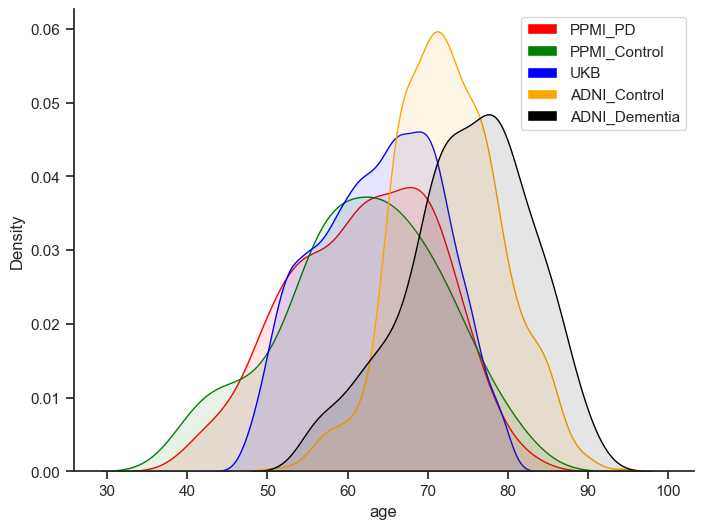

In [129]:
fig, ax = plt.subplots(figsize=(8,6))
sns.despine(top=True, right=True, left=False, bottom=False, offset=None, trim=False)
colorlist = ['red', 'green', 'blue', 'orange', 'black']
labels = []
for e, sd in enumerate(baseline_data['study_diagnosis'].unique()):
    sns.kdeplot(data=baseline_data[baseline_data['study_diagnosis']==sd], x='age',color=colorlist[e], fill=colorlist[e], ax=ax, label=sd, alpha=0.1, linewidth=1,)
    labels.append(sd)

handles = [mpatches.Patch(facecolor=colorlist[e], label=i.replace('UKBB_None', 'UKB')) for e, i in enumerate(labels)]
plt.legend(handles=handles, loc=0)
plt.tight_layout()
plt.savefig("Step1_preprocessing/age_distribution_all_cohorts.png", dpi=200)
plt.savefig("Step1_preprocessing/age_distribution_all_cohorts.svg")
plt.show()

# Gender distribution

In [132]:
baseline_data.groupby(['study_diagnosis', 'gender']).agg({'gender': 'count'})

gender
study_diagnosis gender        
ADNI_Control    F          422
                Female       0
                M          319
                Male         0
                Unk          0
ADNI_Dementia   F          121
                Female       0
                M          168
                Male         0
                Unk          0
PPMI_Control    F            0
                Female      47
                M            0
                Male        98
                Unk          0
PPMI_PD         F            0
                Female     111
                M            0
                Male       208
                Unk          0
UKBB_None       F        22588
                Female       0
                M        20247
                Male         0
                Unk          0

# Prepare files for streamlit tool

In [133]:
import os
from pathlib import Path
import pandas as pd
from lifelines import CoxPHFitter
import numpy as np
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
# import forestplot as fp
from tabulate import tabulate
from matplotlib.ticker import FormatStrFormatter

from lifelines import KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts
from lifelines.datasets import load_waltons
from contextlib import redirect_stdout

from collections import defaultdict

evaluation_generated_dir = Path("/Users/dadua2/projects_data/project_MLPhenotypesMRIGWAS/evaluation_generated_data/23_03_30") / "survival_analysis_cluster"
organized_generated_dir = Path("/Users/dadua2/projects_data/project_MLPhenotypesMRIGWAS/organized_data/23_03_30")
os.makedirs(evaluation_generated_dir, exist_ok=True)

data_all = pd.read_parquet(organized_generated_dir / 'combinedData.parquet.gzip')
data_all['id_invicrot1_vol_temporal_rdktlobes'] = 1 - data_all['id_invicrot1_vol_temporal_rdktlobes']
data_all['id_invicrot1_vol_gmtissues'] = 1 - data_all['id_invicrot1_vol_gmtissues']
data_all['id_invicrot1_vol_left_entorhinaldktcortex'] = 1 - data_all['id_invicrot1_vol_left_entorhinaldktcortex']

subject_max = data_all.set_index('eid')[['Age_i0', 'Age_i1', 'Age_i2', 'Age_i3']].agg(max, axis=1) # - data.set_index('eid')[['Age_i0', 'Age_i1', 'Age_i2', 'Age_i3']].agg(min, axis=1)
subject_max = subject_max.reset_index().groupby('eid').agg('max')[0]
study_time = dict(zip(list(subject_max.index), list(subject_max.values)))

data = data_all.copy() # [data_all['ukbb_id_nih'].str.contains('20252_2_0')].copy().set_index('eid')

In [134]:
organized_nih_path = Path("/Users/EssentialCodeBase/data/clinical/organized_data/23_03_ukbb/nih_dnanexus_230317")
ukbb_clinical_data = pd.read_parquet(organized_nih_path / "participantCharacteristics.parquet.gzip")


In [135]:
raw_data_path = Path("/Users/EssentialCodeBase/data/clinical/raw_data/23_03_ukbb/nih_dnanexus_230317")
data_list = []
for e in range(len(os.listdir(raw_data_path / 'imaging_biomarker_cognitive'))):
    data_list.append(pd.read_csv(raw_data_path / f"imaging_biomarker_cognitive/imaging_biomarker_cognitive_{e}_project_fields_23_03.csv.gz"))


def get_common_indices(data_list):
    # Combine data using pieces using patient index
    selected_patient_index = list(set.intersection(*map(set, [data_list[i]['eid'].values for i in range(len(data_list))])))
    print("Number of patients", len(selected_patient_index))
    data = pd.concat([data_list[e].set_index('eid').loc[selected_patient_index] for e in range(len(data_list))], axis=1)
    print("Shape of concatenated data", data.shape)
    data = data.loc[:, ~data.columns.duplicated()].copy()
    print("Drop duplicated columns", data.shape)
    return data


nih_data = get_common_indices(data_list).reset_index()

/var/folders/y5/tr1yp82s2ns2_4g_6flxk45jrqb07t/T/ipykernel_72570/3271304515.py:4: DtypeWarning: Columns (2,6,16,17,25,27,38,47,49,50,53,70,77,78,92,93) have mixed types. Specify dtype option on import or set low_memory=False.
  data_list.append(pd.read_csv(raw_data_path / f"imaging_biomarker_cognitive/imaging_biomarker_cognitive_{e}_project_fields_23_03.csv.gz"))
/var/folders/y5/tr1yp82s2ns2_4g_6flxk45jrqb07t/T/ipykernel_72570/3271304515.py:4: DtypeWarning: Columns (3,10,14,15,16,28,29,55,57,59,63,68,70,71,72,77,98) have mixed types. Specify dtype option on import or set low_memory=False.
  data_list.append(pd.read_csv(raw_data_path / f"imaging_biomarker_cognitive/imaging_biomarker_cognitive_{e}_project_fields_23_03.csv.gz"))
/var/folders/y5/tr1yp82s2ns2_4g_6flxk45jrqb07t/T/ipykernel_72570/3271304515.py:4: DtypeWarning: Columns (5,14,21,24,27,32,40,47,48,63,67,68,69,84,90) have mixed types. Specify dtype option on import or set low_memory=False.
  data_list.append(pd.read_csv(raw_data_

Number of patients 502387
Shape of concatenated data (502387, 1794)
Drop duplicated columns (502387, 1710)


In [136]:
pc_data = nih_data[['eid']].copy().rename(columns={'eid': 'IID'})

In [137]:
col_rn = {}
for i in range(1, 11):
    pc_data[f'pc{i}'] =  nih_data[f'p22009_a{i}'].values

In [138]:
pc_data

,IID,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10
0,2097153,-11.53190,4.02887,-2.786470,0.382339,-4.036950,1.751570,0.125581,-2.149600,-0.805255,1.539440
1,5242881,-11.82300,1.26643,-0.430540,-0.281423,-0.491189,1.726960,0.856721,1.567190,1.388630,-0.869868
2,3145731,-11.33960,1.62085,-1.287520,2.370630,-5.148740,1.627040,-0.196365,-2.231230,0.861577,0.787777
3,4194308,-12.42640,1.79265,-2.471930,-1.426550,-0.434498,-0.623471,3.484260,3.406740,-3.223780,-1.370190
4,3145729,78.28770,-117.28800,78.933500,24.817800,-3.975770,-3.802220,-2.841740,-4.055550,-2.052640,-6.534530
...,...,...,...,...,...,...,...,...,...,...,...
502382,5242869,-12.52150,1.01588,1.406200,2.026410,-2.451070,1.533970,3.352110,-0.343544,-2.416730,2.399090
502383,1048564,-9.88989,2.76671,-3.700570,-0.991052,-2.821400,-0.448518,0.155195,-1.216150,0.402192,-1.303620
502384,5242872,-10.04000,1.80412,3.235950,-9.554090,7.211580,-3.534950,-4.618610,-2.803120,1.796630,3.617760
502385,4194297,-11.74190,5.15146,-0.670776,-0.797595,-3.561300,-2.790080,1.146850,-1.234980,4.091260,0.388259


In [139]:
new_data = pd.read_csv("/Users/dadua2/EssentialCodeBase/data/clinical/raw_data/23_03_ukbb/card/ukb672198.csv")

/var/folders/y5/tr1yp82s2ns2_4g_6flxk45jrqb07t/T/ipykernel_72570/80522655.py:1: DtypeWarning: Columns (439,440,441,443,445,447) have mixed types. Specify dtype option on import or set low_memory=False.
  new_data = pd.read_csv("/Users/dadua2/EssentialCodeBase/data/clinical/raw_data/23_03_ukbb/card/ukb672198.csv")


In [140]:
mapping_MS_26254 = dict(zip(list(new_data['eid']), list(new_data['26254-0.0'])))
mapping_SCZ_26275 = dict(zip(list(new_data['eid']), list(new_data['26275-0.0'])))
mapping_ISS_26248 = dict(zip(list(new_data['eid']), list(new_data['26248-0.0'])))
mapping_HT_26244 = dict(zip(list(new_data['eid']), list(new_data['26244-0.0'])))
mapping_AD_26206 = dict(zip(list(new_data['eid']), list(new_data['26206-0.0'])))

In [141]:
data['MS_PRS'] = data['eid_nih'].map(mapping_MS_26254)
data['SCZ_PRS'] = data['eid_nih'].map(mapping_SCZ_26275)
data['ISS_PRS'] = data['eid_nih'].map(mapping_ISS_26248)
data['HT_PRS'] = data['eid_nih'].map(mapping_HT_26244)
data['AD_PRS'] = data['eid_nih'].map(mapping_AD_26206)
data['PD_PRS'] = data['PD_prs'].values
data['study_diagnosis'] = 'UKBB_ALL'

In [142]:
H = data.copy()
# H['age_ukbb'] = H['Age.when.attended.assessment.centre_nih'].values
H['age'] = (H['Date_of_attending_assessment_centre'] - H['birthMonthYear']) / 365
H['subject_id'] = H['eid_nih'].values
# H['years_from_baseline'] = (H['Date_of_attending_assessment_centre'] - H['Date_of_attending_assessment_centre_i2']) / 365
# H['baseline_age'] = H['Age_i2']

In [143]:
s = H.groupby('subject_id').agg({'age': 'min'})
bage = dict(zip(list(s.index), list(s['age'])))
H['baseline_age'] = H['subject_id'].map(bage)
H['years_from_baseline'] = H['age'] - H['baseline_age']

In [144]:
required_columns = {
    'AD_imaging_score': "un_AD_score", 
    'PD_imaging_score': "un_PD_score",
    'norm_AD_imaging_score': "AD_score", 
    'norm_PD_imaging_score': "PD_score",
    'MS_PRS': 'MS_PRS',
    'SCZ_PRS': 'SCZ_PRS',
    'ISS_PRS': 'ISS_PRS',
    'HT_PRS': 'HT_PRS',
    'AD_PRS': 'AD_PRS',
    'PD_PRS': 'PD_PRS',
    'townsend': 'townsend',
    'Sex': 'gender',
    'ukbb_id_nih': 'ukbb_id_nih',
    'Date_of_ALL_DEMENTIA': 'Date_of_ALL_DEMENTIA',
    'Date_of_PD': 'Date_of_PD',
    'Date_of_MND': 'Date_of_MND',
    'Date_of_FTD': 'Date_of_FTD',
    'Date_of_VAD': 'Date_of_VAD',
    'Date_of_AD': 'Date_of_AD',
    'Date_of_all_cause_death': 'Date_of_all_cause_death',
    'Date_of_STROKE': 'Date_of_STROKE',
    'Date_of_MS': 'Date_of_MS',
    'Date_of_OtMOVEMENT': 'Date_of_OtMOVEMENT',
    'Date_of_DYSTONIA': 'Date_of_DYSTONIA',
    'Date_of_SMA': 'Date_of_SMA',
    'Date_of_EPILEPSY': 'Date_of_EPILEPSY',
    # 'Date_of_attending_assessment_centre': 'age',
}

In [145]:
disease_columns = {
    'Date_of_ALL_DEMENTIA': 'Date_of_ALL_DEMENTIA',
    'Date_of_PD': 'Date_of_PD',
    'Date_of_MND': 'Date_of_MND',
    'Date_of_FTD': 'Date_of_FTD',
    'Date_of_VAD': 'Date_of_VAD',
    'Date_of_AD': 'Date_of_AD',
    'Date_of_all_cause_death': 'Date_of_all_cause_death',
    'Date_of_STROKE': 'Date_of_STROKE',
    'Date_of_MS': 'Date_of_MS',
    'Date_of_OtMOVEMENT': 'Date_of_OtMOVEMENT',
    'Date_of_DYSTONIA': 'Date_of_DYSTONIA',
    'Date_of_SMA': 'Date_of_SMA',
    'Date_of_EPILEPSY': 'Date_of_EPILEPSY',
}

for col in disease_columns:
    H['_'.join(col.split('_')[2:])] = H[col].map(lambda x: '_'.join(str(col).split('_')[2:]) if not pd.isnull(x) else f"HC_{'_'.join(str(col).split('_')[2:])}")
    required_columns['_'.join(col.split('_')[2:])] = '_'.join(col.split('_')[2:])
    H['ageDiagnosis_' + '_'.join(col.split('_')[2:])] = (H[col] - H['birthMonthYear'])/365
    required_columns['ageDiagnosis_' + '_'.join(col.split('_')[2:])] = 'ageDiagnosis_' + '_'.join(col.split('_')[2:])
    

In [146]:
more_cols = list(required_columns)
more_cols += ['subject_id', 'baseline_age', 'years_from_baseline', 'study_diagnosis', 'age']

In [147]:
K = H[more_cols].rename(columns=required_columns).copy()

In [148]:
diagnosis = []
from tqdm import tqdm
for i in tqdm(range(len(K))):
    # if pd.isnull(LOPOL.iloc[i]['Date_of_ALL_DEMENTIA']) and pd.isnull(LOPOL.iloc[i]['Date_of_PD']) and pd.isnull(LOPOL.iloc[i]['Date_of_PD']) 
    # and pd.isnull(LOPOL.iloc[i]['Date_of_PD']) and pd.isnull(LOPOL.iloc[i]['Date_of_PD']):
    #     diagnosis.append("HC")
    if not pd.isnull(K.iloc[i]['Date_of_ALL_DEMENTIA']):
        diagnosis.append('ALL_DEMENTIA')
    elif not pd.isnull(K.iloc[i]['Date_of_PD']):
        diagnosis.append('PD')
    elif not pd.isnull(K.iloc[i]['Date_of_AD']):
        diagnosis.append('AD')
    elif not pd.isnull(K.iloc[i]['Date_of_VAD']):
        diagnosis.append('VAD')
    elif not pd.isnull(K.iloc[i]['Date_of_MND']):
        diagnosis.append('MND')
    elif not pd.isnull(K.iloc[i]['Date_of_FTD']):
        diagnosis.append('FTD')
    elif not pd.isnull(K.iloc[i]['Date_of_MS']):
        diagnosis.append('MS')
    elif not pd.isnull(K.iloc[i]['Date_of_STROKE']):
        diagnosis.append('STROKE')
    # elif (LOPOL.iloc[i]['age'] > 68):
    #    diagnosis.append("HC")
    else:
        diagnosis.append("HC")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46212/46212 [00:15<00:00, 2903.05it/s]


In [149]:
K['study_diagnosis'] = diagnosis
K['study_diagnosis'] = 'UKBB_' + K['study_diagnosis']

In [150]:
K = pd.merge(K, pc_data.rename(columns={'IID': 'subject_id'}), left_on='subject_id', right_on='subject_id')

In [151]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
K.loc[K[['HT_PRS', 'ISS_PRS']].dropna().index, 'pca_HT_ISS_PRS'] = pca.fit_transform(K[['HT_PRS', 'ISS_PRS']].dropna().values)

In [152]:
pca = PCA(n_components=2)
K.loc[K[['HT_PRS', 'ISS_PRS', 'MS_PRS', 'AD_PRS', 'PD_PRS', 'SCZ_PRS']].dropna().index, 'pca1_prs'] = pca.fit_transform(K[['HT_PRS', 'ISS_PRS', 'MS_PRS', 'AD_PRS', 'PD_PRS', 'SCZ_PRS']].dropna().values)[:,0]
K.loc[K[['HT_PRS', 'ISS_PRS', 'MS_PRS', 'AD_PRS', 'PD_PRS', 'SCZ_PRS']].dropna().index, 'pca2_prs'] = pca.fit_transform(K[['HT_PRS', 'ISS_PRS', 'MS_PRS', 'AD_PRS', 'PD_PRS', 'SCZ_PRS']].dropna().values)[:,1]

In [153]:
s = K.groupby('subject_id').agg({'age': 'count'})
long_subjects = s[s['age']>1].index
not_longitudinal_data = K[~(K['subject_id'].isin(long_subjects))].copy()

In [154]:
longitudinal_data = K[K['subject_id'].isin(long_subjects)].copy()
crossectional_data = K.sort_values(by=['subject_id', 'age']).drop_duplicates(subset=['subject_id']).copy()
combined_data = K.copy()

In [155]:
combined_data.to_csv("streamlit_app/ukbb_combined_data2.csv", index=False)
crossectional_data.to_csv("streamlit_app/ukbb_baseline_data2.csv", index=False)
longitudinal_data.to_csv("streamlit_app/ukbb_longitudinal_data2.csv", index=False)

In [158]:
# selected_subject = list(crossectional_data[(crossectional_data.ageDiagnosis_PD < crossectional_data.baseline_age)].subject_id)
# selected_subject = list(df_orig[(df_orig.ageDiagnosis_PD < df_orig.baseline_age)].subject_id)
# selected_subject += list(df_orig[pd.isnull(df_orig.ageDiagnosis_PD)].subject_id)
# exec("""selected_subject = list(crossectional_data[(crossectional_data['ageDiagnosis_PD'] < crossectional_data['baseline_age'])]['subject_id'])""")
# exec("""selected_subject += list(crossectional_data[pd.isnull(crossectional_data['ageDiagnosis_PD'])]['subject_id'])""")